In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import hddm 
from patsy import dmatrix 
import numpy as np
# print(hddm.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 10

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pre-processing

In [2]:
!pwd
write_dir = '/Users/Krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/'

/Users/Krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/analysis_nbs


In [3]:
all_sim_data = hddm.load_csv('/Users/Krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/probC_sim_data.csv')

In [4]:
all_sim_data.head(10)

,rt,response,gen_drift,gen_bound,subj_idx,cond
0,0.402,1,0.010972,0.437844,0,lc
1,0.700,0,0.010972,1.130616,0,lc
2,0.700,0,0.010972,0.577709,0,lc
3,0.272,1,1.000000,0.566803,0,lc
4,0.432,0,1.000000,0.728452,0,lc
5,0.642,1,1.000000,0.935573,0,lc
6,0.342,1,1.000000,0.631435,0,lc
7,0.272,1,1.000000,0.566420,0,lc
8,0.272,1,1.000000,0.565895,0,lc
9,0.272,1,1.000000,0.568015,0,lc


In [5]:
all_sim_data.columns = all_sim_data.columns.str.strip()
all_sim_data.head()
data = all_sim_data[['response', 'rt', 'cond', 'subj_idx']] 
data = data.rename(index=str, columns={"cond": "stim"})

In [6]:
data.columns = data.columns.str.strip()
data['stim'] = data['stim'].str.strip()
data.head()

,response,rt,stim,subj_idx
0,1,0.402,lc,0
1,0,0.700,lc,0
2,0,0.700,lc,0
3,1,0.272,lc,0
4,0,0.432,lc,0


In [7]:
data = hddm.utils.flip_errors(data)

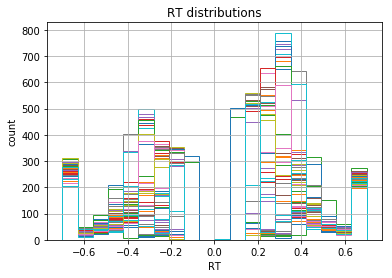

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [9]:
conf_df = data[(data.stim=='hc')|( data.stim=='lc')]
conf_df.head()
vol_df = data[(data.stim=='hv')|( data.stim=='lv')]
vol_df.head()

,response,rt,stim,subj_idx
60000,1,0.402,lv,0
60001,0,-0.700,lv,0
60002,1,0.700,lv,0
60003,0,-0.700,lv,0
60004,0,-0.282,lv,0


In [10]:
np.unique(vol_df.stim), np.unique(conf_df.stim)

(array(['hv', 'lv'], dtype=object), array(['hc', 'lc'], dtype=object))

In [11]:
np.unique(vol_df.subj_idx), np.unique(conf_df.subj_idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [12]:
conf_df = conf_df.rename(index=str, columns={"stim": "conf"})
vol_df = vol_df.rename(index=str, columns={"stim": "vol"})

## Within-subjects regression 

#### Treatment specifies intercept (comparison condition) 
#### C(x) specifies categorical predictor 

##### (design matrix will auto-code dummy variables)

#### trialwise response ~ categorical predictor, intercept condition 

In [13]:
formula="0+C(stim)"
d_mat = dmatrix(formula, data)
print(d_mat.design_info.column_names)
print(d_mat)
sum(d_mat)

['C(stim)[hc]', 'C(stim)[hv]', 'C(stim)[lc]', 'C(stim)[lv]']
[[ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 ..., 
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]]


array([ 30000.,  30000.,  30000.,  30000.])

In [14]:
d_mat

DesignMatrix with shape (120000, 4)
  C(stim)[hc]  C(stim)[hv]  C(stim)[lc]  C(stim)[lv]
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
            0            0            1            0
          

In [15]:
v_reg_model = "v ~"+ formula
a_reg_model = "a ~"+ formula
av_reg_model = [v_reg_model, a_reg_model]

In [16]:
v_within_subj_sim = hddm.HDDMRegressor(data, v_reg_model)
v_within_subj_sim.sample(5000,burn=200, dbname='v_traces_sim.db', db='pickle')

Adding these covariates:
['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]']


/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 38446.8 sec

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [17]:
a_within_subj_sim = hddm.HDDMRegressor(data, a_reg_model)
a_within_subj_sim.sample(5000,burn=200,dbname='a_traces_sim.db', db='pickle')

Adding these covariates:
['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]']


/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 62044.5 sec

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [18]:
av_within_subj_sim = hddm.HDDMRegressor(data, av_reg_model)
av_within_subj_sim.sample(5000,burn=200,dbname='av_traces_sim.db', db='pickle')

Adding these covariates:
['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]']
Adding these covariates:
['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]']


/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 48185.1 sec

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


#### save models

In [19]:
v_within_subj_sim.save(write_dir+'v_within_subj_sim')
a_within_subj_sim.save(write_dir+'a_within_subj_sim')
av_within_subj_sim.save(write_dir+'av_within_subj_sim')

#### extract DIC score

In [20]:
v_within_subj_sim.dic, a_within_subj_sim.dic, av_within_subj_sim.dic

(37358.687151992846, 35786.716707983578, 34604.678338709375)

#### plot within-subjects effects for winning model

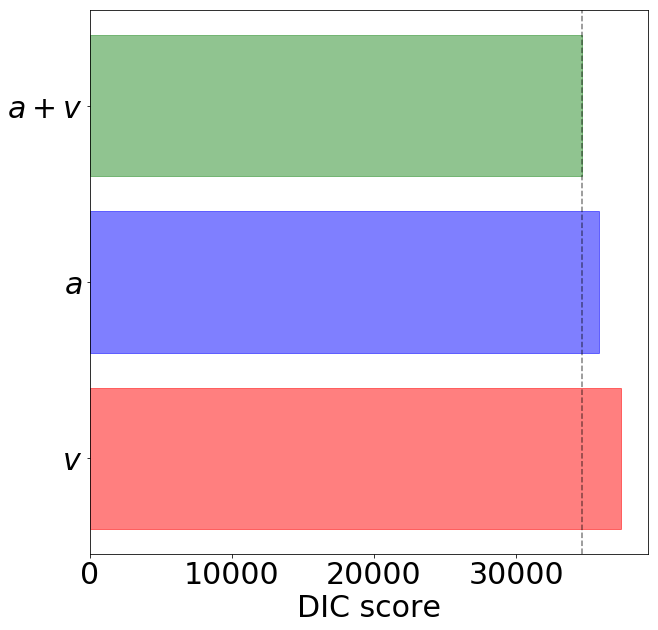

In [21]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

names = [r'$v$',r'$a$',r'$a+v$']
dics = [v_within_subj_sim.dic,  a_within_subj_sim.dic, av_within_subj_sim.dic]
bars = plt.barh(names, dics, alpha=0.5)
plt.xlabel('DIC score')

bars[0].set_color('r')
bars[1].set_color('blue')
bars[2].set_color('forestgreen')

plt.axvline(av_within_subj_sim.dic, color='k', alpha=0.5, linestyle = '--')

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0.5,1,'All groups: Group mean posteriors of within-subj_simect drift-rate effects.')

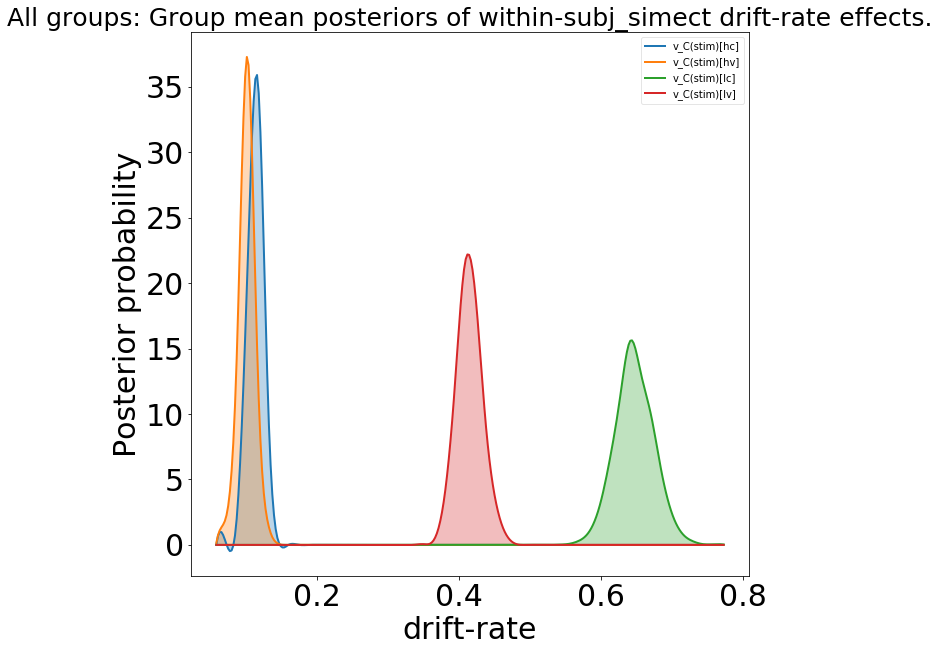

In [31]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_sim.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']


hddm.analyze.plot_posterior_nodes([v_hc, v_hv, v_lc, v_lv ])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('All groups: Group mean posteriors of within-subj_simect drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

Text(0.5,1,'Conflict: Group mean posteriors of within-subject drift-rate effects.')

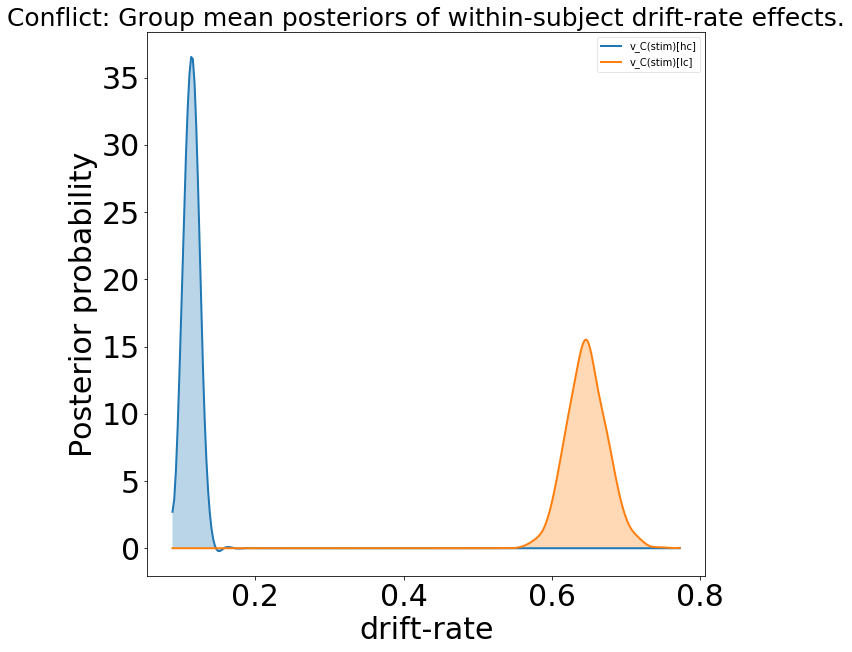

In [32]:
hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Conflict: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0.5,1,'All Groups: Group mean posteriors of within-subject bound effects.')

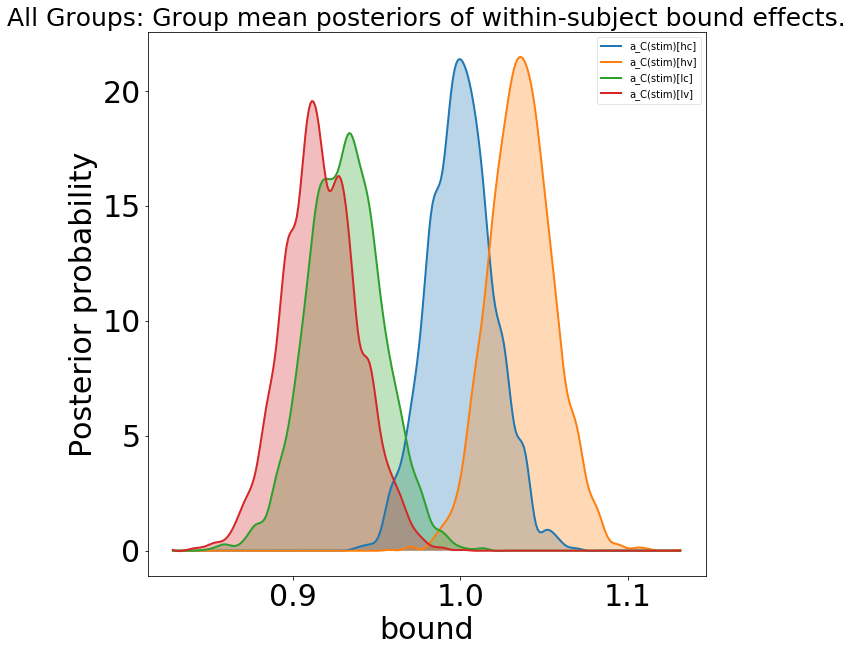

In [24]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_sim.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
bound_fig = hddm.analyze.plot_posterior_nodes([a_hc, a_hv, a_lc, a_lv])
plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('All Groups: Group mean posteriors of within-subject bound effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

Text(0.5,1,'Volatility: Group mean posteriors of within-subject bound effects.')

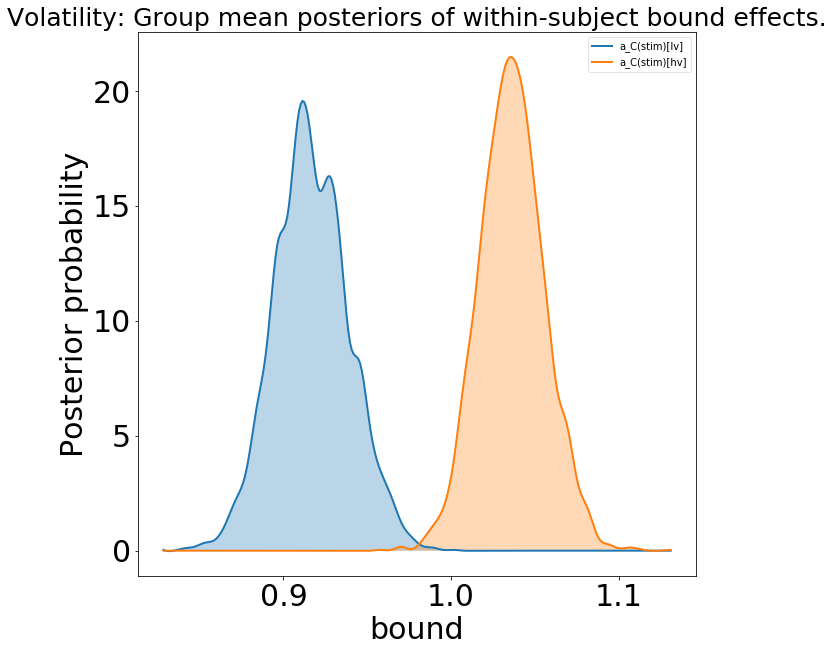

In [25]:
hddm.analyze.plot_posterior_nodes([a_lv, a_hv])

plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('Volatility: Group mean posteriors of within-subject bound effects.')

#### extract DIC score

#### all stats

In [26]:
# v_within_subj.print_stats()

In [33]:
# tst hyp. that bound ^ with vol
print("P(HV > LV) = ", (a_hv.trace() > a_lv.trace()).mean())
# tst hyp. that drift dc. with conf
print("P(HC < LC) = ", (v_hc.trace() < v_lc.trace()).mean())

P(HV > LV) =  1.0
P(HC < LC) =  1.0
